In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import folium
from folium.plugins import HeatMap
import geopy
from geopy.geocoders import Nominatim
from folium.vector_layers import CircleMarker

import os
from IPython.core.display import HTML

In [3]:
# Data Import - Read in Cleaned CSV File (Cleaned in contracts_cleaning.ipynb)
contracts = pd.read_csv("data/usaspending_data/contracts.csv")

In [4]:
# Edit Recipient Names (if duplicates found in minority outputs)
contracts['recipient_name'] = contracts['recipient_name'].replace({'BAYASSOCIATES INCORPORATED':'BAYASSOCIATES, INC.', 'BAYASSOCIATES, INC': 'BAYASSOCIATES, INC.'})
contracts['recipient_name'] = contracts['recipient_name'].replace({'TERESA TRIANA':'TERESA, TRIANA'})
contracts['recipient_name'] =  contracts['recipient_name'].replace({'BEATRICE COCKRELL':'COCKRELL, BEATRICE'})



In [5]:
# Create Shorthands for Funding Agencies 
contracts['funding_agency_name'] = contracts['funding_agency_name'].replace({'DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT (HUD)': 'HUD',
                                                                            'ENVIRONMENTAL PROTECTION AGENCY (EPA)': 'EPA',
                                                                            'DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS)': 'HHS',
                                                                            'NATIONAL SCIENCE FOUNDATION (NSF)' : 'NSF',
                                                                            'DEPARTMENT OF TRANSPORTATION (DOT)': 'DOT'})

In [7]:
# Add State to recipient names for easier geolocatino
contracts['recipient_city_name'] = contracts['recipient_city_name'] + ', MA'

In [6]:
# Creates a dataframe with the number of each type of naics (a business type classification)
naics = contracts.groupby(['naics_description'])[['contract_award_unique_key']].count()

In [10]:
# Creates a dataframe with the naics occur the most (the top 5, roughly more than 1000 appearances each)
top_naics = naics.sort_values(by='contract_award_unique_key', ascending=False)[:5].index
contracts['top_naics'] = contracts['naics_description'].isin(top_naics)

In [11]:
# Create instance for Nominatim for geo-location of cities 
geolocator = Nominatim(timeout=10)
cities = contracts['recipient_city_name'].unique()

/Users/pippidebree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [14]:
# Add latitude and longitude attributes to new dataset
coords = pd.Series(cities).apply(geolocator.geocode).apply(lambda x: pd.Series({'Latitude':x.latitude, 'Longitude':x.longitude}))                       

In [15]:
# Add cities names to latitude and longitude dataset
cities = pd.Series(cities)
coords['recipient_city_name'] = cities

In [16]:
# Add geo-locations to contracts dataset
contracts = contracts.merge(coords, how='left', on='recipient_city_name')

In [17]:
# Create a random shuffle of latitude and longitude in order to more easily visualize on map (no point overlap)
contracts['Latitude_shuf'] = contracts['Latitude'].apply(lambda x: x + np.random.uniform(-0.01, 0.01))
contracts['Longitude_shuf'] =  contracts['Longitude'].apply(lambda x: x + np.random.uniform(-0.01, 0.01))

In [18]:
# Create a contract length (years) variable
contracts['con_len'] = contracts['end_year'] - contracts['start_year']

In [19]:
# Create Sub-frames for Black, Hispanic and Minority Owned Businesses 
bbe = contracts.loc[contracts['black_american_owned_business'] == True]
hbe = contracts.loc[contracts['hispanic_american_owned_business'] == True]
mbe = contracts.loc[contracts['minority_owned_business'] == True]

In [20]:
# Reports all Black American Owned Businesses and the number grants they have recieved 
bbe.groupby(['recipient_name'])['contract_award_unique_key'].count()

recipient_name
AKRIVIS TECHNOLOGIES, LLC              2
APHIOS CORPORATION                     3
ATAASK GLOBAL INC.                     2
BAYASSOCIATES, INC.                    5
BRYANT ASSOCIATES, INC.                2
CLARENDON VALUATION ADVISORS, LLC      2
COCKRELL, BEATRICE                     9
GONA, PHILIMON                         1
GORDON, PATRICK                        2
HARLOW SCIENTIFIC, LLC                 1
INTELIMAP INC                          2
JMW SYSTEMS                            1
WESTCARB ENTERPRISES, INC.             3
WESTNET, INC.                        564
WINDWALKER GROUP, LLC                  1
Name: contract_award_unique_key, dtype: int64

In [21]:
# Reports all Black American Owned Businesses and the number grants they have recieved 
bbe.groupby(['recipient_name', 'naics_description'])['recipient_name', 'naics_description'].head()

recipient_name  \
62               BRYANT ASSOCIATES, INC.   
112              BRYANT ASSOCIATES, INC.   
551    CLARENDON VALUATION ADVISORS, LLC   
769                      GORDON, PATRICK   
791                        INTELIMAP INC   
807                      GORDON, PATRICK   
816                        INTELIMAP INC   
6888          WESTCARB ENTERPRISES, INC.   
6904          WESTCARB ENTERPRISES, INC.   
6916          WESTCARB ENTERPRISES, INC.   
7345                  APHIOS CORPORATION   
7474           AKRIVIS TECHNOLOGIES, LLC   
7532           AKRIVIS TECHNOLOGIES, LLC   
7851                       WESTNET, INC.   
7857                       WESTNET, INC.   
7864                       WESTNET, INC.   
7875                       WESTNET, INC.   
7880                       WESTNET, INC.   
10211                      WESTNET, INC.   
10231                      WESTNET, INC.   
10234                      WESTNET, INC.   
10246                      WESTNET, INC.   
10251                      WESTNET, INC.   
10378                      WESTNET, INC.   
10380                      WESTNET, INC.   
10382                      WESTNET, INC.   
10383                      WESTNET, INC.   
10631                 APHIOS CORPORATION   
10769                     GONA, PHILIMON   
12684                 APHIOS CORPORATION   
12805                      WESTNET, INC.   
13409             HARLOW SCIENTIFIC, LLC   
14108                        JMW SYSTEMS   
15233                      WESTNET, INC.   
15235                      WESTNET, INC.   
15254                      WESTNET, INC.   
15256                      WESTNET, INC.   
15413                 COCKRELL, BEATRICE   
15415                 COCKRELL, BEATRICE   
15420                BAYASSOCIATES, INC.   
15421                BAYASSOCIATES, INC.   
15424                BAYASSOCIATES, INC.   
15426                 COCKRELL, BEATRICE   
15442                 COCKRELL, BEATRICE   
15445                 COCKRELL, BEATRICE   
15446                 COCKRELL, BEATRICE   
15447                 COCKRELL, BEATRICE   
15450                 COCKRELL, BEATRICE   
15452                BAYASSOCIATES, INC.   
15453                BAYASSOCIATES, INC.   
15454                 COCKRELL, BEATRICE   
16358              WINDWALKER GROUP, LLC   
16433  CLARENDON VALUATION ADVISORS, LLC   
17427                 ATAASK GLOBAL INC.   
18481                 ATAASK GLOBAL INC.   

                                       naics_description  
62     SURVEYING AND MAPPING (EXCEPT GEOPHYSICAL) SER...  
112    SURVEYING AND MAPPING (EXCEPT GEOPHYSICAL) SER...  
551                    OFFICES OF REAL ESTATE APPRAISERS  
769                    ENVIRONMENTAL CONSULTING SERVICES  
791                 OTHER MANAGEMENT CONSULTING SERVICES  
807                              GRANTMAKING FOUNDATIONS  
816                 OTHER MANAGEMENT CONSULTING SERVICES  
6888                       HARDWARE MERCHANT WHOLESALERS  
6904                       HARDWARE MERCHANT WHOLESALERS  
6916                       HARDWARE MERCHANT WHOLESALERS  
7345           RESEARCH AND DEVELOPMENT IN BIOTECHNOLOGY  
7474           RESEARCH AND DEVELOPMENT IN BIOTECHNOLOGY  
7532           RESEARCH AND DEVELOPMENT IN BIOTECHNOLOGY  
7851       SURGICAL AND MEDICAL INSTRUMENT MANUFACTURING  
7857       SURGICAL AND MEDICAL INSTRUMENT MANUFACTURING  
7864       SURGICAL AND MEDICAL INSTRUMENT MANUFACTURING  
7875       SURGICAL AND MEDICAL INSTRUMENT MANUFACTURING  
7880       SURGICAL AND MEDICAL INSTRUMENT MANUFACTURING  
10211  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
10231  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
10234  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
10246  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
10251  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
10378     ANALYTICAL LABORATORY INSTRUMENT MANUFACTURING  
10380  OTHER PRESSED AND BLOWN GLASS AND GLASSWARE MA...  
10382                  ELEC

In [22]:
# Reports all Hispanic American Owned Businesses and the number grants they have recieved 
hbe.groupby(['recipient_name'])['contract_award_unique_key'].count()

recipient_name
BIODIRECT INC.                            4
BLANCO, EDGAR E                           1
BRUNETTE, MARIA                           1
CONVERGENCE MEDICAL DEVICES INC.          1
CORTES, DHARMA E                          3
GVC CONSTRUCTION AND ENGINEERING, INC.    1
MEDICAL SPECIALTIES DISTRIBUTORS, LLC     1
MIKRON, INC                               5
MOURA'S CLEANING SERVICE, INC.            2
NEO-ADVENT TECHNOLOGIES LLC               1
TERESA, TRIANA                            1
UNIC PRO, INC.                            4
Name: contract_award_unique_key, dtype: int64

In [23]:
# Reports all Black American Owned Businesses and the number grants they have recieved 
hbe.groupby(['recipient_name', 'naics_description'])['recipient_name', 'naics_description'].head()

recipient_name  \
980                           BLANCO, EDGAR E   
2066   GVC CONSTRUCTION AND ENGINEERING, INC.   
2142           MOURA'S CLEANING SERVICE, INC.   
2159           MOURA'S CLEANING SERVICE, INC.   
3656                          BRUNETTE, MARIA   
4842              NEO-ADVENT TECHNOLOGIES LLC   
5070                           UNIC PRO, INC.   
7187                         CORTES, DHARMA E   
7194                         CORTES, DHARMA E   
7196                         CORTES, DHARMA E   
7314                           BIODIRECT INC.   
8423                           TERESA, TRIANA   
11270                             MIKRON, INC   
11343                             MIKRON, INC   
11391                             MIKRON, INC   
11639                          BIODIRECT INC.   
11703        CONVERGENCE MEDICAL DEVICES INC.   
12261                          BIODIRECT INC.   
12289                          BIODIRECT INC.   
12414   MEDICAL SPECIALTIES DISTRIBUTORS, LLC   
14503                             MIKRON, INC   
15773                          UNIC PRO, INC.   
16302                          UNIC PRO, INC.   
16438                          UNIC PRO, INC.   
18353                             MIKRON, INC   

                                       naics_description  
980                    ENVIRONMENTAL CONSULTING SERVICES  
2066            HIGHWAY, STREET, AND BRIDGE CONSTRUCTION  
2142                                 JANITORIAL SERVICES  
2159                                 JANITORIAL SERVICES  
3656   RESEARCH AND DEVELOPMENT IN THE PHYSICAL, ENGI...  
4842   RESEARCH AND DEVELOPMENT IN THE PHYSICAL, ENGI...  
5070                                LANDSCAPING SERVICES  
7187   RESEARCH AND DEVELOPMENT IN THE SOCIAL SCIENCE...  
7194   RESEARCH AND DEVELOPMENT IN THE SOCIAL SCIENCE...  
7196   RESEARCH AND DEVELOPMENT IN THE SOCIAL SCIENCE...  
7314   OTHER PROFESSIONAL EQUIPMENT AND SUPPLIES MERC...  
8423             TRANSLATION AND INTERPRETATION SERVICES  
11270  OTHER ELECTRONIC AND PRECISION EQUIPMENT REPAI...  
11343                IRRADIATION APPARATUS MANUFACTURING  
11391     ANALYTICAL LABORATORY INSTRUMENT MANUFACTURING  
11639  OTHER PROFESSIONAL EQUIPMENT AND SUPPLIES MERC...  
11703     ANALYTICAL LABORATORY INSTRUMENT MANUFACTURING  
12261  OTHER PROFESSIONAL EQUIPMENT AND SUPPLIES MERC...  
12289  OTHER PROFESSIONAL EQUIPMENT AND SUPPLIES MERC...  
12414  MEDICAL, DENTAL, AND HOSPITAL EQUIPMENT AND SU...  
14503                ALL OTHER BUSINESS SUPPORT SERVICES  
15773                                JANITORIAL SERVICES  
16302                           PARKING LOTS AND GARAGES  
16438                                JANITORIAL SERVICES  
18353     ANALYTICAL LABORATORY INSTRUMENT MANUFACTURING

In [24]:
# Reports the mean amount given to each Black American Owned Business
bbe.groupby(['recipient_name'])['obligated_amount'].mean()

recipient_name
AKRIVIS TECHNOLOGIES, LLC            262186.000000
APHIOS CORPORATION                   181159.666667
ATAASK GLOBAL INC.                     7262.980000
BAYASSOCIATES, INC.                   60697.000000
BRYANT ASSOCIATES, INC.              349354.250000
CLARENDON VALUATION ADVISORS, LLC     90543.090000
COCKRELL, BEATRICE                     2971.666667
GONA, PHILIMON                        33000.000000
GORDON, PATRICK                        3306.000000
HARLOW SCIENTIFIC, LLC                36045.000000
INTELIMAP INC                         30325.000000
JMW SYSTEMS                            7735.700000
WESTCARB ENTERPRISES, INC.              468.320000
WESTNET, INC.                         10751.934929
WINDWALKER GROUP, LLC                497153.000000
Name: obligated_amount, dtype: float64

In [25]:
# Reports the mean amount given to each Black American Owned Business
hbe.groupby(['recipient_name'])['obligated_amount'].mean()

recipient_name
BIODIRECT INC.                             37317.325000
BLANCO, EDGAR E                             1000.000000
BRUNETTE, MARIA                            20000.000000
CONVERGENCE MEDICAL DEVICES INC.           27000.000000
CORTES, DHARMA E                            1678.056667
GVC CONSTRUCTION AND ENGINEERING, INC.     57655.000000
MEDICAL SPECIALTIES DISTRIBUTORS, LLC       9975.000000
MIKRON, INC                                 6962.720000
MOURA'S CLEANING SERVICE, INC.            910872.845000
NEO-ADVENT TECHNOLOGIES LLC               497310.000000
TERESA, TRIANA                              4858.500000
UNIC PRO, INC.                            120761.272500
Name: obligated_amount, dtype: float64

In [26]:
# Reports the difference in mean obligated amount between black owned and non-black owned businesses 
print(contracts['annual_revenue'].mean() )
print(contracts[contracts['minority_owned_business'] == True]['annual_revenue'].mean())
print(contracts[contracts['black_american_owned_business'] == True]['annual_revenue'].mean())
print(contracts[contracts['hispanic_american_owned_business'] == True]['annual_revenue'].mean())


5818828338.933037
3623861.283333333
453811.76978417265
7790130.782608695


In [27]:
# Reports the difference in mean obligated amount between black owned and non-black owned businesses 
print(contracts['obligated_amount'].mean() )
print(contracts[contracts['minority_owned_business'] == True]['obligated_amount'].mean())
print(contracts[contracts['black_american_owned_business'] == True]['obligated_amount'].mean())
print(contracts[contracts['hispanic_american_owned_business'] == True]['obligated_amount'].mean())


264245.84250229923
31068.202784679084
14998.489333333346
124468.254


In [28]:
# Reports the difference in mean obligated amount between black owned and non-black owned businesses 
contracts.groupby(['black_american_owned_business'])['obligated_amount'].mean() 

black_american_owned_business
False    272608.444521
True      14998.489333
Name: obligated_amount, dtype: float64

In [29]:
# Reports the difference in mean obligated amount between hispanic owned and non-black owned businesses 
contracts.groupby(['hispanic_american_owned_business'])['obligated_amount'].mean() 

hispanic_american_owned_business
False    264435.160939
True     124468.254000
Name: obligated_amount, dtype: float64

In [30]:
# Reports the difference in mean obligated amount between minority and non-minority owned businesses 
contracts.groupby(['minority_owned_business'])['obligated_amount'].mean() 

minority_owned_business
False    277104.756698
True      31068.202785
Name: obligated_amount, dtype: float64

In [31]:
# Reports the number of contracts given by each funding agency in the data 
contracts.groupby(['funding_agency_name'])[['contract_award_unique_key']].count()

contract_award_unique_key
funding_agency_name                           
DOT                                          4
EPA                                       2699
HHS                                      15487
HUD                                        199
NSF                                         94

In [32]:
# Reports the number of contracts given by each funding agency to black owned businesses 
bbe.groupby(['funding_agency_name'])[['contract_award_unique_key']].count()

contract_award_unique_key
funding_agency_name                           
EPA                                          9
HHS                                        575
HUD                                         16

In [33]:
# Reports the number of contracts given by each funding agency to hispanic owned businesses 
hbe.groupby(['funding_agency_name'])[['contract_award_unique_key']].count()

contract_award_unique_key
funding_agency_name                           
EPA                                          4
HHS                                         21

In [34]:
# Reports the number of contracts given by each funding agency to minority owned businesses 
mbe.groupby(['funding_agency_name'])[['contract_award_unique_key']].count()

contract_award_unique_key
funding_agency_name                           
EPA                                         46
HHS                                        903
HUD                                         17

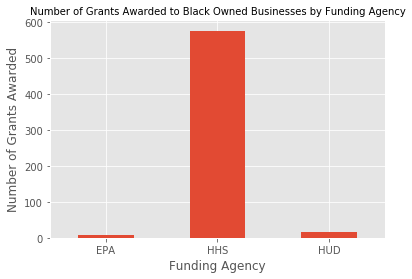

In [35]:
# Shows the number of contracts awarded by each funding agency to both black owned and non-black owned businesses
bbe.groupby(['funding_agency_name'])['contract_award_unique_key'].count().plot(kind="bar", legend=False)#.unstack().plot.bar()
#plt.legend(loc='center left')
plt.ylabel("Number of Grants Awarded")
plt.xlabel("Funding Agency")
plt.xticks(rotation="horizontal")
plt.title("Number of Grants Awarded to Black Owned Businesses by Funding Agency", fontsize=10)
plt.show()


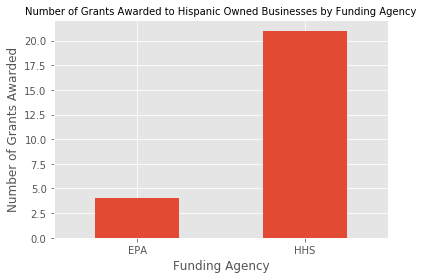

In [36]:
# Shows the number of contracts awarded by each funding agency to both black owned and non-black owned businesses
hbe.groupby(['funding_agency_name'])['contract_award_unique_key'].count().plot(kind="bar" ,legend=False)#.unstack().plot.bar()
plt.ylabel("Number of Grants Awarded")
plt.xlabel("Funding Agency")
plt.xticks(rotation="horizontal")
plt.title("Number of Grants Awarded to Hispanic Owned Businesses by Funding Agency", fontsize=10)
plt.show()


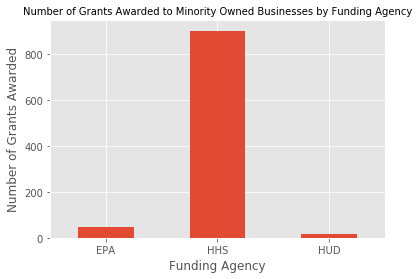

In [37]:
# Shows the number of contracts awarded by each funding agency to both black owned and non-black owned businesses
mbe.groupby(['funding_agency_name'])['contract_award_unique_key'].count().plot(kind="bar", legend=False)#.unstack().plot.bar()
plt.ylabel("Number of Grants Awarded")
plt.xlabel("Funding Agency")
plt.xticks(rotation="horizontal")
plt.title("Number of Grants Awarded to Minority Owned Businesses by Funding Agency", fontsize=10)
plt.show()


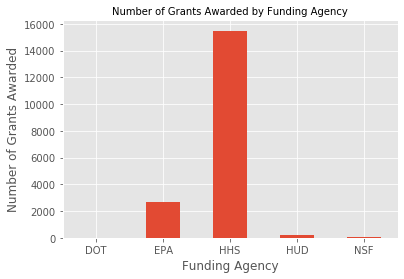

In [38]:
# Shows the number of contracts awarded by each funding agency to both black owned and non-black owned businesses
contracts.groupby(['funding_agency_name'])['contract_award_unique_key'].count().plot(kind="bar", legend=False)#.unstack().plot.bar()
plt.ylabel("Number of Grants Awarded")
plt.xlabel("Funding Agency")
plt.xticks(rotation="horizontal")
plt.title("Number of Grants Awarded by Funding Agency", fontsize=10)
plt.show()

In [39]:
# Creates sub-frames for black, hispanic and minority owned businesses grouped by the funding agency
# Then the proportions of each minority group, for each funding agency
norm_mbe = contracts.groupby(['funding_agency_name'])['minority_owned_business'].value_counts(normalize=True).unstack()
norm_bbe = contracts.groupby(['funding_agency_name'])['black_american_owned_business'].value_counts(normalize=True).unstack()
norm_hbe = contracts.groupby(['funding_agency_name'])['hispanic_american_owned_business'].value_counts(normalize=True).unstack()

In [40]:
# Map the meaning of true/false so that labels are less confusing 
norm_mbe = norm_mbe.rename(columns={True: "Minority Owned", False: "Not Minority Owned"})
norm_bbe = norm_bbe.rename(columns={True: "Black Owned", False: "Not Black Owned"})
norm_hbe = norm_hbe.rename(columns={True: "Hispanic Owned", False: "Not Hispanic Owned"})

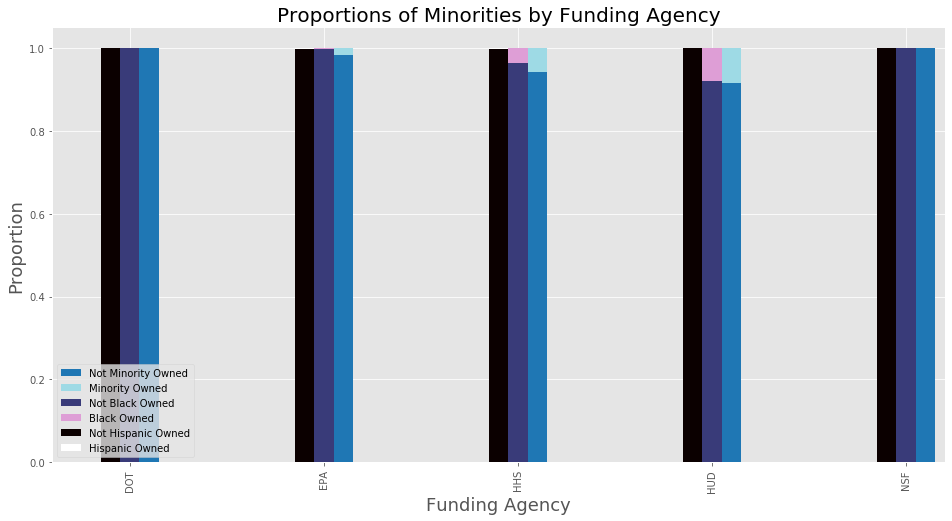

In [41]:
# Plots the proportions of each minority group recieving grants from individual funding agencies 


fig = plt.figure(figsize = [8, 4.8])
ax = fig.add_subplot(111)
fig.set_size_inches(16, 8)
fig.subplots_adjust(wspace = 0.)

norm_mbe.plot(kind='bar', stacked=True, width = 0.1, colormap="tab20", position=-0.5, ax=ax, align='center') 
norm_bbe.plot(kind='bar', stacked=True, width = 0.1, colormap="tab20b", position=0.5, ax=ax, align='center')
norm_hbe.plot(kind='bar', stacked=True, width = 0.1, colormap = "hot", position=1.5, ax=ax, align='center')

ax.spines['right'].set_smart_bounds

plt.legend(loc='lower left', 
           fontsize = 'medium')

plt.xlabel('Funding Agency', fontsize=18)
plt.ylabel('Proportion', fontsize=18)
plt.title("Proportions of Minorities by Funding Agency", fontsize=20)


plt.show()


In [42]:
rep_count = contracts.groupby('recipient_name')[['contract_award_unique_key']].count()
rep_count = rep_count.rename(columns={'contract_award_unique_key': 'number_of_grants'})

In [43]:
reps=rep_count.merge(contracts.groupby('recipient_name')[['annual_revenue']].mean(), left_index=True, right_index=True)


In [44]:
reps = reps.merge(contracts.groupby('recipient_name')[['minority_owned_business']].any(), left_index=True, right_index=True)

In [45]:
reps = reps.merge(contracts.groupby('recipient_name')[['black_american_owned_business']].any(), left_index=True, right_index=True)

In [46]:
reps = reps.merge(contracts.groupby('recipient_name')[['hispanic_american_owned_business']].any(), left_index=True, right_index=True)

In [47]:
reps_no = reps.dropna()

reps_no = reps_no[reps_no['annual_revenue'].astype(int) < 0.5e+11]
reps_no = reps_no[reps_no['number_of_grants'] < 20]

Text(0.5, 1.0, 'Number of Grants Recieved by an Enterprise against Annual Revenue\n (For Enterprises with less than 20 grants \nand Revenue less than 50 Billion)')

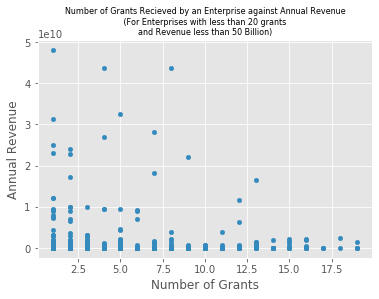

In [48]:
reps_no.plot(kind='scatter', x='number_of_grants', y='annual_revenue')
plt.xlabel('Number of Grants')#, fontsize=18)
plt.ylabel('Annual Revenue')#, fontsize=18)
plt.title("Number of Grants Recieved by an Enterprise against Annual Revenue\n " +
          "(For Enterprises with less than 20 grants \nand Revenue less than 50 Billion)", fontsize=8)

#xlocs()
#xlabs([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400])

#locs, xlabs = plt.xticks()
#plt.xticks([100, 200, 300, 400, 500, 600, 700, 800])


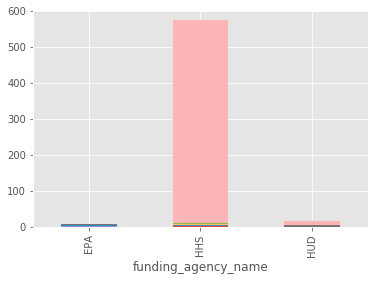

In [49]:
bbe.groupby(['funding_agency_name', 'recipient_name'])[['contract_award_unique_key']].count().unstack().plot(kind='bar',stacked=True, legend=False)
plt.show()

In [167]:
# Reports the difference in the annual revenue between sole proprietorship and non-sole proprietorships
contracts.groupby(['sole_proprietorship'])['annual_revenue'].mean() 

sole_proprietorship
False    5.918330e+09
True     1.730749e+09
Name: annual_revenue, dtype: float64

In [173]:
# Find total number of sole proprietorships
len(contracts[contracts['sole_proprietorship'] == True].groupby(['recipient_name'])['recipient_name'])
          
          

103

In [174]:
# Find number of unique receipients 
len(contracts.groupby(['recipient_name'])['recipient_name'])

1474

In [175]:
# Creates sub-frames for each minority group and calculates the number of sole proprietorships in each group
sole_mbe = mbe.groupby(['sole_proprietorship'])['contract_award_unique_key'].count()
sole_bbe = bbe.groupby(['sole_proprietorship'])['contract_award_unique_key'].count()
sole_hbe = hbe.groupby(['sole_proprietorship'])['contract_award_unique_key'].count()
sole_total = contracts.groupby('sole_proprietorship')['contract_award_unique_key'].count()

In [176]:
# Concatenates sub-frames in order to plot the proportions
sole_1 = pd.concat([sole_total, sole_mbe], axis=1, keys=["Total", "MBE"])
sole_2 = pd.concat([sole_bbe, sole_hbe], axis=1, keys=["BBE", "HBE"])
sole = pd.concat([sole_1, sole_2], axis=1)

In [177]:
# Turns the counts of sole proprietorships in each minority group into proportions for easier comparison 
sole['MBE'] = sole['MBE'] / sole['MBE'].sum()
sole['BBE'] = sole['BBE'] / sole['BBE'].sum()
sole['HBE'] = sole['HBE'] / sole['HBE'].sum()
sole['Total'] = sole['Total'] / sole['Total'].sum()

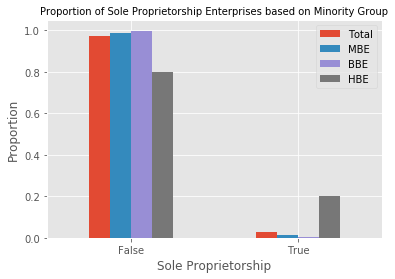

In [178]:
# Plots the proportions of sole proprietorships for each minority group and the whole set of contracts 
sole.plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Sole Proprietorship")
plt.xticks(rotation="horizontal")
plt.title("Proportion of Sole Proprietorship Enterprises based on Minority Group", fontsize=10)
plt.savefig("Proportion of Sole Proprietorship Enterprises based on Minority Group")

In [41]:
# Creates sub-frames with counts for the number of top naics for each minority (as true or false)
naics_mbe = mbe.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_bbe = bbe.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_hbe = hbe.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_total = contracts.groupby(['top_naics'])['contract_award_unique_key'].count()

In [42]:
# Creates a dataframe with the counts of tops naics and non-top naics for each minority group
naics_1 = pd.concat([naics_total, naics_mbe], axis=1, keys=["Total", "MBE"])
naics_2 = pd.concat([naics_bbe, naics_hbe], axis=1, keys=["BBE", "HBE"])
naics_sum = pd.concat([naics_1, naics_2], axis=1)

In [43]:
# Manually calculate the proportions for each minority group 
naics_sum['MBE'] = naics_sum['MBE'] / naics_sum['MBE'].sum()
naics_sum['BBE'] = naics_sum['BBE'] / naics_sum['BBE'].sum()
naics_sum['HBE'] = naics_sum['HBE'] / naics_sum['HBE'].sum()
naics_sum['Total'] = naics_sum['Total'] / naics_sum['Total'].sum()

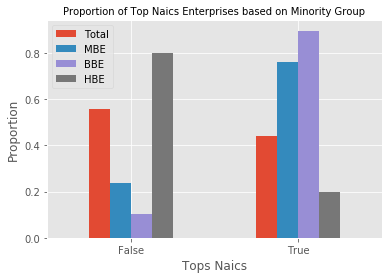

In [44]:
# Plots the proportions of top naics for each minority group
naics_sum.plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Tops Naics")
plt.xticks(rotation="horizontal")
plt.title("Proportion of Top Naics Enterprises based on Minority Group", fontsize=10)
plt.savefig("Proportion of Top Naics Enterprises based on Minority Group")

In [51]:
# Create black owned subframe, without Westnet (the black owned business receiving a majority (564/600) of contracts
# to black owned businesses)
bbe_no_westnet = bbe[bbe['recipient_name'] != 'WESTNET, INC.']


In [52]:
# Creates sub-frames with counts for the number of top naics for each minority (as true or false)
naics_mbe = mbe.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_bbe = bbe_no_westnet.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_hbe = hbe.groupby(['top_naics'])['contract_award_unique_key'].count()
naics_total = contracts.groupby(['top_naics'])['contract_award_unique_key'].count()

In [53]:
# Creates a dataframe with the counts of tops naics and non-top naics for each minority group
naics_1 = pd.concat([naics_total, naics_mbe], axis=1, keys=["Total", "MBE"])
naics_2 = pd.concat([naics_bbe, naics_hbe], axis=1, keys=["BBE", "HBE"])
naics_sum = pd.concat([naics_1, naics_2], axis=1)

In [54]:
# Manually calculate the proportions for each minority group 
naics_sum['MBE'] = naics_sum['MBE'] / naics_sum['MBE'].sum()
naics_sum['BBE'] = naics_sum['BBE'] / naics_sum['BBE'].sum()
naics_sum['HBE'] = naics_sum['HBE'] / naics_sum['HBE'].sum()
naics_sum['Total'] = naics_sum['Total'] / naics_sum['Total'].sum()

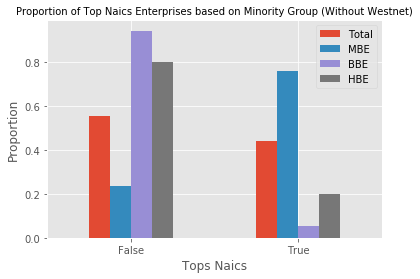

In [56]:
# Plots the proportions of top naics for each minority group (Without Westnet)
naics_sum.plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Tops Naics")
plt.xticks(rotation="horizontal")
plt.title("Proportion of Top Naics Enterprises based on Minority Group (Without Westnet)", fontsize=10)
plt.savefig("Proportion of Top Naics Enterprises based on Minority Group")

In [61]:
# Create dataframe of unique naics for black owned businesses receiving grants
bbe_naics = pd.Series(bbe['naics_description'].unique())
bbe_naics_counts = bbe_naics.isin(top_naics).value_counts()

In [62]:
# Create dataframe of unique naics for hispanic owned businesses receiving grants
hbe_naics = pd.Series(hbe['naics_description'].unique())
hbe_naics_counts = hbe_naics.isin(top_naics).value_counts()

In [63]:
# Create dataframe of unique naics for minority owned businesses receiving grants
mbe_naics = pd.Series(mbe['naics_description'].unique())
mbe_naics_counts =mbe_naics.isin(top_naics).value_counts()

In [64]:
# Create dataframe of unique naics for all receiving grants
tot_naics = pd.Series(contracts['naics_description'].unique())
tot_naics_counts = tot_naics.isin(top_naics).value_counts()

In [67]:
# Concatenates sub-frames in order to plot the proportions
top_naics_1 = pd.concat([tot_naics_counts, mbe_naics_counts], axis=1, keys=["Total", "MBE"])
top_naics_2 = pd.concat([bbe_naics_counts, hbe_naics_counts], axis=1, keys=["BBE", "HBE"])
top_naics_minor = pd.concat([top_naics_1, top_naics_2], axis=1)

In [68]:
top_naics_minor

Total  MBE  BBE  HBE
False    363   63   17   11
True       5    4    3    3

In [69]:
# Manually calculate the proportions for each minority group 
top_naics_minor['MBE'] = top_naics_minor['MBE'] / top_naics_minor['MBE'].sum()
top_naics_minor['BBE'] = top_naics_minor['BBE'] / top_naics_minor['BBE'].sum()
top_naics_minor['HBE'] = top_naics_minor['HBE'] / top_naics_minor['HBE'].sum()
top_naics_minor['Total'] = top_naics_minor['Total'] / top_naics_minor['Total'].sum()

In [237]:
top_naics_minor 

Total       MBE   BBE       HBE
False  0.932065  0.746269  0.65  0.642857
True   0.067935  0.253731  0.35  0.357143

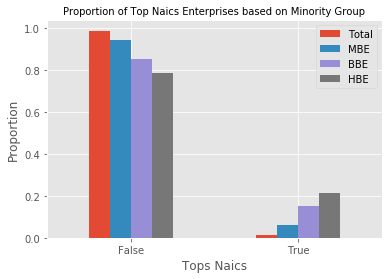

In [70]:
# Plots the proportions of top naics for each minority group
top_naics_minor.plot(kind='bar')
plt.ylabel("Proportion")
plt.xlabel("Tops Naics")
plt.xticks(rotation="horizontal")
plt.title("Proportion of Top Naics Enterprises based on Minority Group", fontsize=10)
plt.savefig("Proportion of Top Naics Enterprises based on Minority Group")

In [72]:
# creates an instance of the folium map in order to plot the locations of recipients
def generateBaseMap(defaultlocation = [42.4072, -71.3824]):
    """Creates a basemap onto which datapoints can be added"""
    base_map = folium.Map(location = defaultlocation)
    return base_map


In [219]:
# Base Map Creation for Heatmap
base_map_total = generateBaseMap()

# Creates a heatmap, using the Folium Heatmap Plugin
heatmap_data_shuf = contracts[["Latitude_shuf", "Longitude_shuf"]] 
HeatMap(data = heatmap_data_shuf, radius=8, max_zoom=13).add_to(base_map_total)

# Saves the created basemap 
base_map_total.save('maps/total_contracts_map.html')
#display(base_map_total)

In [220]:
# Base Map Creation for Heatmap
base_map_bbe = generateBaseMap()

# Creates a heatmap, using the Folium Heatmap Plugin
heatmap_data = bbe[["Latitude_shuf", "Longitude_shuf"]] 
HeatMap(data = heatmap_data, radius=8, max_zoom=13).add_to(base_map_bbe)

# Saves the created basemap 
base_map_bbe.save('maps/bbe_contracts_map.html')
#display(base_map_bbe)

In [221]:
# Base Map Creation for Heatmap
base_map_hbe = generateBaseMap()

# Creates a heatmap, using the Folium Heatmap Plugin
heatmap_data = hbe[["Latitude_shuf", "Longitude_shuf"]]
HeatMap(data = heatmap_data, radius=8, max_zoom=13).add_to(base_map_hbe)

# Saves the created basemap 
base_map_hbe.save('maps/hbe_contracts_map.html')
#display(base_map_hbe)

In [222]:
# Base Map Creation for Heatmap
base_map_mbe = generateBaseMap()

# Creates a heatmap, using the Folium Heatmap Plugin
heatmap_data = mbe[["Latitude_shuf", "Longitude_shuf"]] 
HeatMap(data = heatmap_data, radius=8, max_zoom=25).add_to(base_map_mbe)

# Saves the created basemap 
base_map_mbe.save('maps/mbe_contracts_map.html')
#display(base_map_mbe)

In [73]:
# Creates a dataframe with recipients based in Boston proper
boston_contracts = contracts[contracts['recipient_city_name'] == "BOSTON, MA"]

In [207]:
# Lists black owned businesses based in Boston receiving contracts
boston_contracts[boston_contracts['black_american_owned_business'] == True]

contract_award_unique_key  obligated_amount  \
62               CONT_AWD_0003_9700_W912WJ15D0002_9700          58676.00   
112              CONT_AWD_0006_9700_W912WJ15D0002_9700         640032.50   
551         CONT_AWD_DU204SB12P0025_8600_-NONE-_-NONE-         104408.00   
6888   CONT_AWD_HHSI248201100079G_7527_GS21F0154W_4730            325.20   
16358        CONT_AWD_68HE0D18C0030_6800_-NONE-_-NONE-         497153.00   
16433                       CONT_IDV_DU204SA12C01_8600          76678.18   

      period_of_performance_start_date period_of_performance_current_end_date  \
62                              6/7/16                           6/20/17 0:00   
112                            3/14/17                           9/14/18 0:00   
551                            9/27/12                           9/26/14 0:00   
6888                            5/5/11                           5/11/11 0:00   
16358                          10/1/18                           9/30/20 0:00   
16433                          6/15/12                                    NaN   

      funding_agency_name                       funding_sub_agency_name  \
62                    EPA               ENVIRONMENTAL PROTECTION AGENCY   
112                   EPA               ENVIRONMENTAL PROTECTION AGENCY   
551                   HUD  HOUSING AND URBAN DEVELOPMENT, DEPARTMENT OF   
6888                  HHS                         INDIAN HEALTH SERVICE   
16358                 EPA               ENVIRONMENTAL PROTECTION AGENCY   
16433                 HUD  HOUSING AND URBAN DEVELOPMENT, DEPARTMENT OF   

                          recipient_name  \
62               BRYANT ASSOCIATES, INC.   
112              BRYANT ASSOCIATES, INC.   
551    CLARENDON VALUATION ADVISORS, LLC   
6888          WESTCARB ENTERPRISES, INC.   
16358              WINDWALKER GROUP, LLC   
16433  CLARENDON VALUATION ADVISORS, LLC   

      primary_place_of_performance_county_name recipient_city_name  \
62                                     BRISTOL          BOSTON, MA   
112                                    BRISTOL          BOSTON, MA   
551                                   NEW YORK          BOSTON, MA   
6888                                    MARION          BOSTON, MA   
16358                               WASHINGTON          BOSTON, MA   
16433                                      NaN          BOSTON, MA   

                                       naics_description  ...  \
62     SURVEYING AND MAPPING (EXCEPT GEOPHYSICAL) SER...  ...   
112    SURVEYING AND MAPPING (EXCEPT GEOPHYSICAL) SER...  ...   
551                    OFFICES OF REAL ESTATE APPRAISERS  ...   
6888                       HARDWARE MERCHANT WHOLESALERS  ...   
16358                SECURITY GUARDS AND PATROL SERVICES  ...   
16433                  OFFICES OF REAL ESTATE APPRAISERS  ...   

       nonprofit_organization  other_not_for_profit_organization start_year  \
62                      False                              False         16   
112                     False                              False         17   
551                     False                              False         12   
6888                    False                              False         11   
16358                   False                              False         18   
16433                   False                              False         12   

       end_year  top_naics   Latitude  Longitude  Latitude_shuf  \
62         17.0      False  42.360253 -71.058291      42.355811   
112        18.0      False  42.360253 -71.058291      42.357400   
551        14.0      False  42.360253 -71.058291      42.369630   
6888       11.0      False  42.360253 -71.058291      42.369113   
16358      20.0      False  42.360253 -71.058291      42.354604   
16433       NaN      False  42.360253 -71.058291      42.354861   

       Longitude_shuf  con_len  
62         -71.051961      1.0  
112        -71.052598      1.0  
551        -71.059102  

In [208]:
# Lists hispanic owned businesses based in Boston receiving contracts
boston_contracts[boston_contracts['hispanic_american_owned_business'] == True]

contract_award_unique_key  obligated_amount  \
11703  CONT_AWD_HHSN271201300270P_7529_-NONE-_-NONE-           27000.0   

      period_of_performance_start_date period_of_performance_current_end_date  \
11703                          3/20/13                            5/1/13 0:00   

      funding_agency_name        funding_sub_agency_name  \
11703                 HHS  NATIONAL INSTITUTES OF HEALTH   

                         recipient_name  \
11703  CONVERGENCE MEDICAL DEVICES INC.   

      primary_place_of_performance_county_name recipient_city_name  \
11703                                MIDDLESEX          BOSTON, MA   

                                    naics_description  ...  \
11703  ANALYTICAL LABORATORY INSTRUMENT MANUFACTURING  ...   

       nonprofit_organization  other_not_for_profit_organization start_year  \
11703                   False                              False         13   

       end_year  top_naics   Latitude  Longitude  Latitude_shuf  \
11703      13.0       True  42.360253 -71.058291      42.361088   

       Longitude_shuf  con_len  
11703      -71.050322      0.0  

[1 rows x 34 columns]

In [209]:
# Lists minority owned businesses based in Boston receiving contracts
boston_contracts[boston_contracts['minority_owned_business'] == True]

contract_award_unique_key  obligated_amount  \
62               CONT_AWD_0003_9700_W912WJ15D0002_9700          58676.00   
112              CONT_AWD_0006_9700_W912WJ15D0002_9700         640032.50   
534          CONT_AWD_DU100R13P0007_8600_-NONE-_-NONE-           4000.00   
551         CONT_AWD_DU204SB12P0025_8600_-NONE-_-NONE-         104408.00   
3043    CONT_AWD_HHSD2002014M59655P_7523_-NONE-_-NONE-         150000.00   
3097     CONT_AWD_HHSD200201564147C_7523_-NONE-_-NONE-        1000000.00   
6104     CONT_AWD_HHSI245201300210P_7527_-NONE-_-NONE-          20468.00   
6143     CONT_AWD_HHSI245201400013P_7527_-NONE-_-NONE-          19992.00   
6198     CONT_AWD_HHSI245201500117P_7527_-NONE-_-NONE-          21420.00   
6273     CONT_AWD_HHSI245201600305P_7527_-NONE-_-NONE-          24432.00   
6357     CONT_AWD_HHSI245201700146P_7527_-NONE-_-NONE-          24960.00   
6438     CONT_AWD_HHSI245201800209P_7527_-NONE-_-NONE-          24960.00   
6888   CONT_AWD_HHSI248201100079G_7527_GS21F0154W_4730            325.20   
11536    CONT_AWD_HHSN271201100015C_7529_-NONE-_-NONE-         150000.00   
11703    CONT_AWD_HHSN271201300270P_7529_-NONE-_-NONE-          27000.00   
14151   CONT_AWD_HHSN301201500127PC_7529_-NONE-_-NONE-           3200.00   
16358        CONT_AWD_68HE0D18C0030_6800_-NONE-_-NONE-         497153.00   
16433                       CONT_IDV_DU204SA12C01_8600          76678.18   
17664       CONT_AWD_75N93019C00014_7529_-NONE-_-NONE-         599914.00   
18158       CONT_AWD_75N93018C00017_7529_-NONE-_-NONE-         599997.00   

      period_of_performance_start_date period_of_performance_current_end_date  \
62                              6/7/16                           6/20/17 0:00   
112                            3/14/17                           9/14/18 0:00   
534                            1/28/13                           2/20/14 0:00   
551                            9/27/12                           9/26/14 0:00   
3043                            8/1/14                           3/15/15 0:00   
3097                           9/29/15                           8/31/17 0:00   
6104                          12/18/12                           9/30/13 0:00   
6143                          10/18/13                          10/31/14 0:00   
6198                          11/11/14                          12/31/15 0:00   
6273                          12/22/15                          12/31/16 0:00   
6357                           12/3/16                          12/31/17 0:00   
6438                            1/7/18                          12/31/18 0:00   
6888                            5/5/11                           5/11/11 0:00   
11536                           9/1/11                           5/31/13 0:00   
11703                          3/20/13                            5/1/13 0:00   
14151                          5/13/15                           5/13/15 0:00   
16358                          10/1/18                           9/30/20 0:00   
16433                          6/15/12                                    NaN   
17664                          6/17/19                           6/16/21 0:00   
18158                          7/26/18                           7/31/20 0:00   

      funding_agency_name                       funding_sub_agency_name  \
62                    EPA               ENVIRONMENTAL PROTECTION AGENCY   
112                   EPA               ENVIRONMENTAL PROTECTION AGENCY   
534                   HUD  HOUSING AND URBAN DEVELOPMENT, DEPARTMENT OF   
551                   HUD  HOUSING AND URBAN DEVELOPMENT, DEPARTMENT OF   
3043                  HHS    CENTERS FOR DISEASE CONTROL AND PREVENTION   
3097                  HHS    CENTERS FOR DISEASE CONTROL AND PREVENTION   
6104                  HHS                         INDIAN HEALTH SERVICE   
6143                  HHS                         INDIAN HEALTH SERVICE   
6198                  HHS                         INDIA

In [210]:
# Finds mean number of employees for non-profits 
contracts[contracts['nonprofit_organization'] == True]['number_of_employees'].mean()

6380.432098765432

In [211]:
# Finds mean number of employees for all recipients 
contracts['number_of_employees'].mean()

15139.157179161371

In [214]:
# Reports average length for contracts
print(contracts['con_len'].mean())

1.1532592108131676


In [215]:
# Reports average length for mbe contracts
print(mbe['con_len'].mean())

0.6493236212278877


In [216]:
# Reports average length for bbe contracts
print(bbe['con_len'].mean())

0.8046744574290484


In [217]:
# Reports average length for hbe contracts
print(hbe['con_len'].mean())

0.7083333333333334


In [81]:
# Creates dataframes for the number of contracts awarded to hispanic owned businesses and for overall contracts in each year 
latino_awd_time = contracts[contracts['hispanic_american_owned_business'] == True].groupby("start_year").count()["contract_award_unique_key"]
all_awd_time_l = contracts[contracts["start_year"].isin(latino_awd_time.index)].groupby("start_year").count()["contract_award_unique_key"]

Text(0.5, 1.0, 'Percent of latino business of all awarded business in 2010-2019')

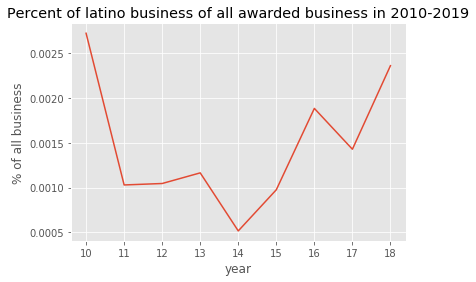

In [82]:
# Plots proportions of contracts awarded to hbes by year
plt.plot(latino_awd_time.index, latino_awd_time / all_awd_time_l)
plt.xlabel("year")
plt.ylabel("% of all business")
plt.title("Percent of latino business of all awarded business in 2010-2019")

In [83]:
# Creates dataframes for the number of contracts awarded to black owned businesses and for overall contracts in each year 
black_awd_time = contracts[contracts['black_american_owned_business'] == True].groupby("start_year").count()["contract_award_unique_key"]
all_awd_time_b = contracts[contracts["start_year"].isin(black_awd_time.index)].groupby("start_year").count()["contract_award_unique_key"]

Text(0.5, 1.0, 'Percent of black business of all awarded business in 2010-2019')

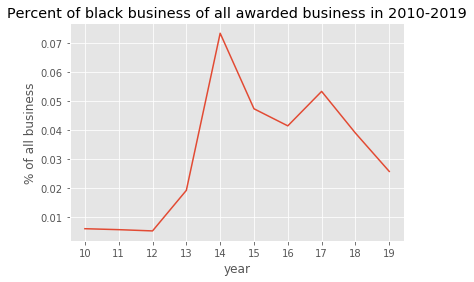

In [84]:
# Plots proportions of contracts awarded to bbes by year
plt.plot(black_awd_time.index, black_awd_time / all_awd_time_b)
plt.xlabel("year")
plt.ylabel("% of all business")
plt.xticks(black_awd_time.index)
plt.title("Percent of black business of all awarded business in 2010-2019")

In [85]:
# Creates dataframes for the number of contracts awarded to minority owned businesses and for overall contracts in each year 
mino_awd_time = contracts[contracts['minority_owned_business'] == True].groupby("start_year").count()["contract_award_unique_key"]
all_awd_time_m = contracts[contracts["start_year"].isin(mino_awd_time.index)].groupby("start_year").count()["contract_award_unique_key"]

Text(0.5, 1.0, 'Percent of minority business of all awarded business in 2010-2019')

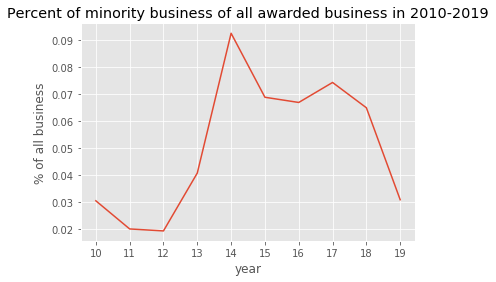

In [86]:
# Plots proportions of contracts awarded to bbes by year
plt.plot(mino_awd_time.index, mino_awd_time / all_awd_time_m)
plt.xlabel("year")
plt.ylabel("% of all business")
plt.xticks(mino_awd_time.index)
plt.title("Percent of minority business of all awarded business in 2010-2019")